In [1]:
import time
import os
import sys

import numpy as np
import matplotlib
matplotlib.use('nbagg')
#from matplotlib import style
#style.use('ggplot')
import matplotlib.pyplot as plt

import astropy.units as u
from astropy import stats, wcs
from astropy.io import fits
from astropy.convolution import Gaussian2DKernel
from astropy.coordinates import SkyCoord

from mmtwfs.wfs import *
from mmtwfs.zernike import ZernikeVector
from mmtwfs.telescope import MMT
import poppy
import photutils

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
sys.path.append("/Users/tim/src/cwfs/python")
%cd /Users/tim/MMT/61_inch/20181219/

/Users/tim/MMT/61_inch/20181219


In [4]:
from lsst.cwfs.instrument import Instrument
from lsst.cwfs.algorithm import Algorithm
from lsst.cwfs.image import Image, readFile
import lsst.cwfs.plots as plots

In [5]:
r = 60
extra_whole = fits.open("rts2focus0012.fits")[1].data # focus = 3190
intra_whole = fits.open("rts2focus0017.fits")[1].data # focus = 1992
#intra = intra_whole[942-18:942+18,158-18:158+18] - np.median(intra_whole)
#extra = extra_whole[945-18:945+18,154-18:154+18] - np.median(extra_whole)
intra = intra_whole[780-r:780+r,503-r:503+r] - np.median(intra_whole)
extra = extra_whole[780-r:780+r,509-r:509+r] - np.median(extra_whole)

<IPython.core.display.Javascript object>


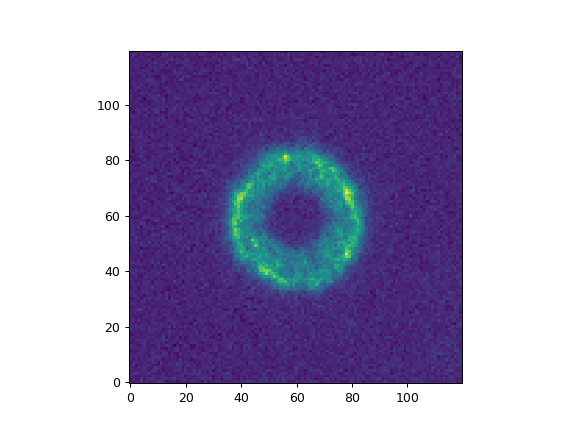

In [6]:
#plt.imshow(intra_whole[942-20:942+20,158-20:158+20], origin="lower")
#plt.imshow(extra_whole[945-20:945+20,154-20:154+20], origin="lower")
plt.imshow(intra, origin="lower")
plt.show()

<IPython.core.display.Javascript object>


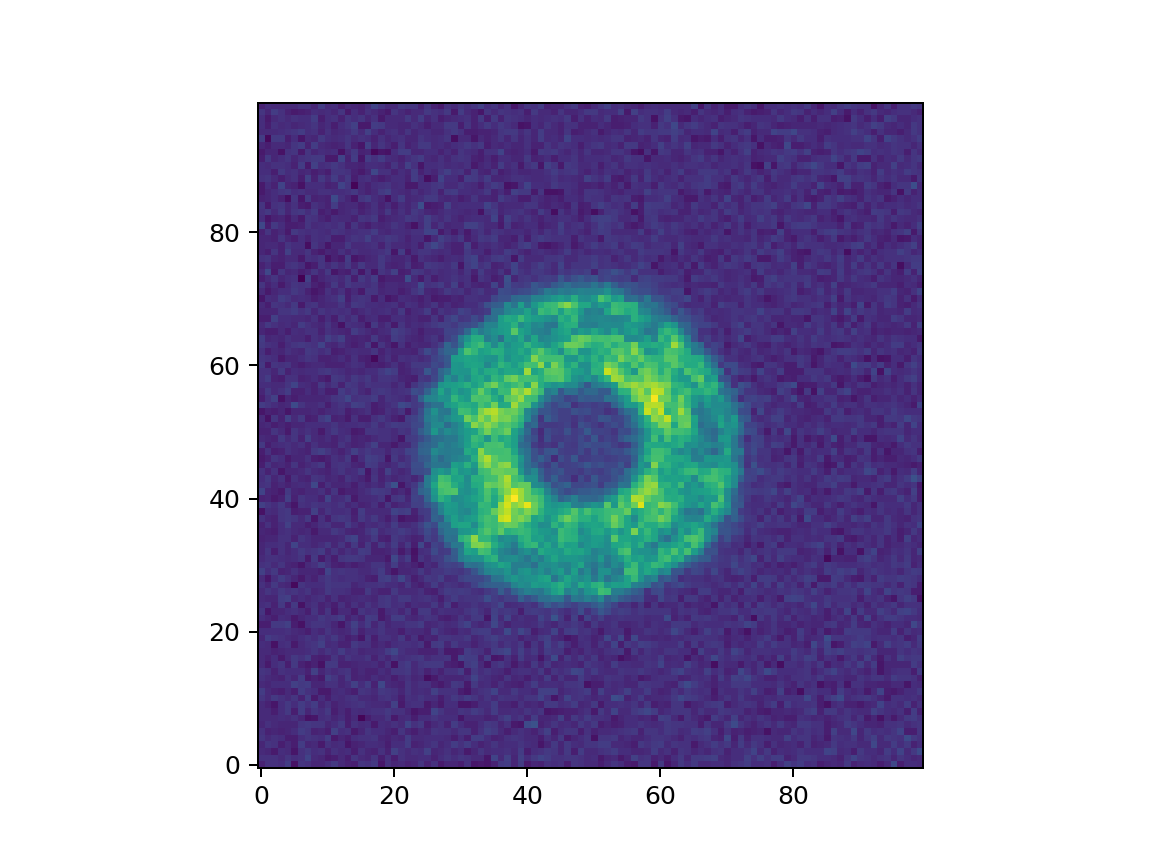

In [6]:
plt.imshow(extra, origin="lower")
plt.show()

In [7]:
fits.writeto("intra.fits", intra, overwrite=True)
fits.writeto("extra.fits", extra, overwrite=True)

These images are binned 3x3 so the pixels are 42 um. Thus the pupil diameter is:

In [8]:
pupsize = 25.25 * 3 * 14
pupsize * u.um

<Quantity 1060.5 um>

The mirror diameter is 1.54 meters and the focal ratio is 13.5. So the focal length is:

In [9]:
diameter = 1.54 * u.m
radius = diameter / 2.
focal_length = diameter * 13.5
focal_length

<Quantity 20.79 m>

Calculate the angle of beam convergence:

In [10]:
ang = np.arctan2(radius, focal_length)
ang

<Quantity 0.03702012 rad>

In [11]:
offset = pupsize / np.tan(ang) * u.um
offset

<Quantity 28633.5 um>

In [12]:
def kuiper_focus(pup_rad, focus, binning=3, direction='out'):
    pupsize = 14 * binning * pup_rad * u.um
    diameter = 1.54 * u.m
    radius = diameter / 2
    focal_length = diameter * 13.5
    beam_ang = np.arctan2(radius, focal_length)
    offset = pupsize / np.tan(beam_ang) * u.um
    counts_per_um = 600. / 28633.5  # empirically determined
    correction = offset.value * counts_per_um
    if 'out' in direction:
        correction *= -1
    return focus + correction

In [13]:
kuiper_focus(25.25, 3190, direction='out')

2590.0

So about 14 mm of focus offset at focal plane for 300 counts of focus change which gives 20 counts/mm. For motion at the secondary, scale by the ratio of the squares of the focal ratios:

In [14]:
counts_per_mm = 600. / offset.to(u.mm).value
counts_per_mm_m2 = counts_per_mm / (13.5**2 / 4.**2)
counts_per_mm, counts_per_mm_m2

(20.954476400020955, 1.8396248142679577)

In [15]:
obscuration = 0.4096 / 1.54
obscuration

0.265974025974026

In [16]:
nmperrad = radius.to(u.nm).value
nmperasec = nmperrad / 206265.
nmperasec

3733.061837926938

In [17]:
fieldXY = [0., 0.]
I1 = Image(readFile("intra.fits"), fieldXY, Image.INTRA)
I2 = Image(readFile("extra.fits"), fieldXY, Image.EXTRA)

<IPython.core.display.Javascript object>


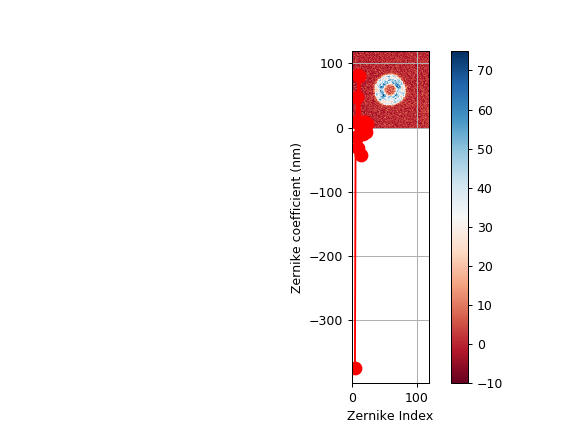

In [18]:
fig, ax = plt.subplots()
im = ax.imshow(I2.image, origin='lower', cmap='RdBu')
cbar = fig.colorbar(im)
fig.show()

In [20]:
kuiper = Instrument('61inch', I1.sizeinPix)

In [21]:
#kuiper.offset = offset.to(u.m).value  # needs to be focus offset between intra and extra positions
kuiper.offset

0.028634

In [22]:
algo = Algorithm('exp', kuiper, 3)

In [23]:
algo.runIt(kuiper, I1, I2, 'onAxis')

resetting images: I1 and I2
imageCoCenter: (x1,y1)=(   60.43,   60.70)

imageCoCenter: (x1,y1)=(   59.23,   59.72)

itr = 0, z4-z22
[-402.  -14.   -1.   51.  -20.   56.    4.   73.    2.    2.  -32.    4.
    2.  -10.   -2.   -3.    7.   -4.    8.]
itr = 1, z4-z22
[-468.  -10.   31.   40.  -16.   48.   11.   75.    1.    2.  -26.    2.
    3.   -8.   -4.   -3.    3.   -3.   -2.]
itr = 2, z4-z22
[-515.   -0.   43.   36.  -10.   43.   18.   74.   -0.    1.  -29.    3.
    2.   -7.   -4.   -3.    2.   -5.   -8.]
itr = 3, z4-z22
[-545.    8.   56.   33.   -6.   41.   24.   74.   -0.    1.  -28.    3.
    1.   -6.   -5.   -2.    2.   -5.  -10.]
itr = 4, z4-z22
[-578.   -2.   73.   74.   -4.   38.   19.   73.    1.    2.  -26.    5.
   -0.  -24.   -4.   -3.    1.   -6.  -12.]
itr = 5, z4-z22
[-505.    1.   66.   31.   -7.   53.   24.   78.    2.    1.  -27.    4.
    0.   -6.   -4.   -2.    2.   -4.   -8.]
itr = 6, z4-z22
[-462.  -19.   54.   54.  -10.   68.   19.   80.    3.    3.  -26.    

In [24]:
print(algo.zer4UpNm)

[-373.82672972  -14.74702685    8.46076505   47.70437384  -31.85888618
   81.43029275  -11.09791341   80.40980238    2.78754921    1.69393212
  -43.08549841    9.4639366     8.34297213   -9.91783341   -2.05401921
    0.8499141     9.01395269   -6.93465254    5.21078698]


In [25]:
plots.plotZer(algo.zer4UpNm, 'nm')

In [26]:
zv = ZernikeVector()
zv.from_array(algo.zer4UpNm, modestart=4, normalized=True)
zv.denormalize()
zv

Fringe Coefficients
 Z04:                -647.5 nm 	 Defocus (2, 0)
 Z05:                -36.12 nm 	 Primary Astig at 45° (2, -2)
 Z06:                 20.72 nm 	 Primary Astig at 0° (2, 2)
 Z07:                 134.9 nm 	 Primary Y Coma (3, -1)
 Z08:                -90.11 nm 	 Primary X Coma (3, 1)
 Z09:                 230.3 nm 	 Y Trefoil (3, -3)
 Z10:                -31.39 nm 	 X Trefoil (3, 3)
 Z11:                 179.8 nm 	 Primary Spherical (4, 0)
 Z12:                 8.815 nm 	 Secondary Astigmatism at 0° (4, 2)
 Z13:                 5.357 nm 	 Secondary Astigmatism at 45° (4, -2)
 Z14:                -136.2 nm 	 X Tetrafoil (4, 4)
 Z15:                 29.93 nm 	 Y Tetrafoil (4, -4)
 Z16:                  28.9 nm 	 Secondary X Coma (5, 1)
 Z17:                -34.36 nm 	 Secondary Y Coma (5, -1)
 Z18:                -7.115 nm 	 Secondary X Trefoil (5, 3)
 Z19:                 2.944 nm 	 Secondary Y Trefoil (5, -3)
 Z20:                 31.23 nm 	 X Pentafoil (5, 5)
 Z21:    

<IPython.core.display.Javascript object>


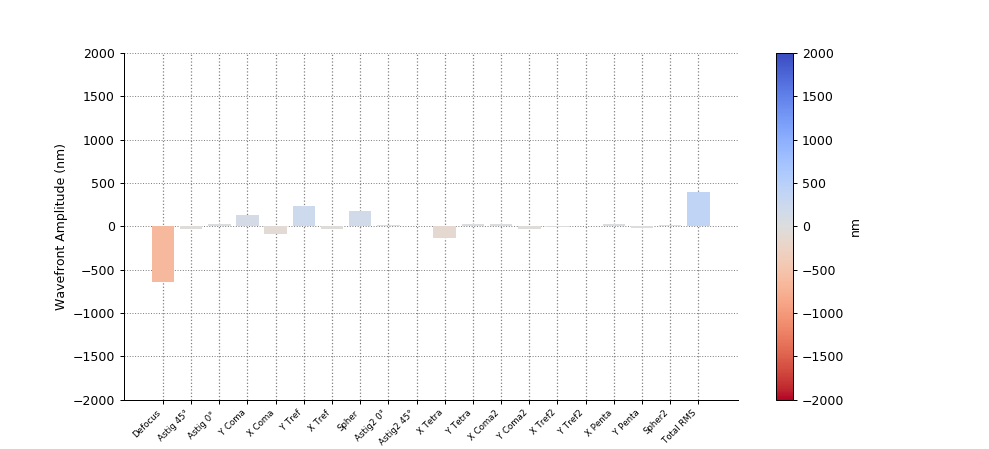

In [27]:
zv.fringe_bar_chart().show()
plt.show()

<IPython.core.display.Javascript object>


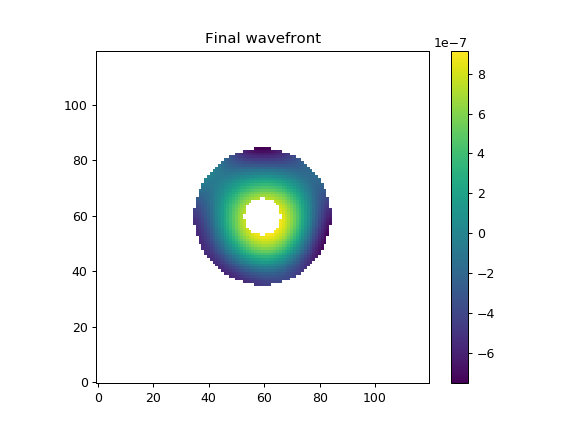

In [28]:
plots.plotImage(algo.Wconverge, "Final wavefront", show=True)

<IPython.core.display.Javascript object>


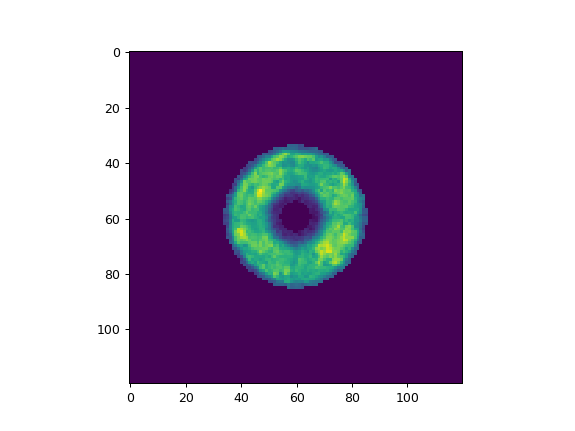

In [29]:
plt.imshow(algo.image)
plt.show()

In [ ]:
plt.close('all')

Scaling seems wrong so try to calculate offset for MMT same way...

In [30]:
pupsize = 135. * 26.
diameter = 6.5 * u.m
radius = diameter / 2.
focal_length = diameter * 5.3
mmt_ang = np.arctan2(radius, focal_length)
offset = 0.5 * pupsize / np.tan(mmt_ang) * u.um
offset

<Quantity 18603. um>

OK, this matches what we're using there.

Use the Z04 term from the CWFS fit and see if we can calculate a focus correction

In [31]:
# this calculates the difference in size between in-focus pupil and observed in um
foc_err = (zv['Z04'] / (nmperasec * u.nm / u.arcsec)) * (100 * u.um / u.arcsec)

# use the tangent of the beam angle to convert pupil size difference to shift in focus position at focal plane.
# convert to focus counts and negate to create correction to send to telescope.
foc_corr = -counts_per_mm * foc_err.to(u.mm).value / np.tan(ang)
foc_corr

<Quantity 9.81310334>

In [32]:
from astropy.nddata import CCDData
from artnfocus.imutils import ARTNreduce, sub_background, find_donuts

<IPython.core.display.Javascript object>


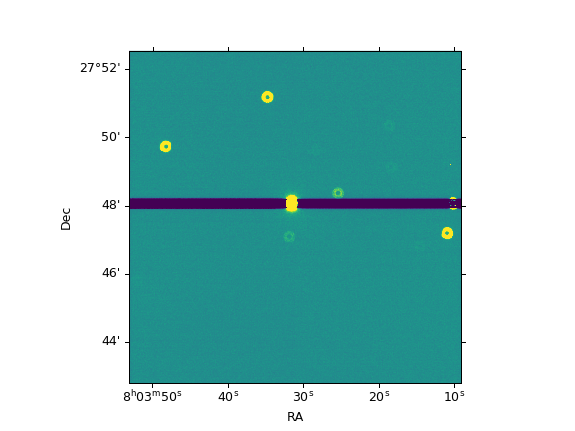

In [33]:
im = ARTNreduce("rts2focus0012.fits")
#im.data = sub_background(im)
norm = wfs_norm(im)
plt.subplot(projection=im.wcs)
plt.imshow(im, origin='lower', norm=norm)
plt.xlabel('RA')
plt.ylabel('Dec')
plt.show()

In [34]:
segm, cat = find_donuts(im)

<IPython.core.display.Javascript object>


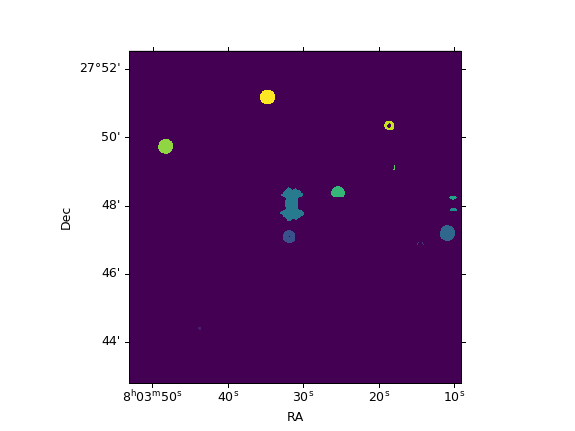

In [35]:
plt.subplot(projection=im.wcs)
plt.imshow(segm, origin='lower')
plt.xlabel('RA')
plt.ylabel('Dec')
plt.show()

In [36]:
cat.to_table()

id,xcentroid,ycentroid,sky_centroid,sky_centroid_icrs,source_sum,source_sum_err,background_sum,background_mean,background_at_centroid,xmin,xmax,ymin,ymax,min_value,max_value,minval_xpos,minval_ypos,maxval_xpos,maxval_ypos,area,equivalent_radius,perimeter,semimajor_axis_sigma,semiminor_axis_sigma,eccentricity,orientation,ellipticity,elongation,covar_sigx2,covar_sigxy,covar_sigy2,cxx,cxy,cyy
,pix,pix,"deg,deg","deg,deg",,,,,,pix,pix,pix,pix,,,pix,pix,pix,pix,pix2,pix,pix,pix,pix,,rad,,,pix2,pix2,pix2,1 / pix2,1 / pix2,1 / pix2
int64,float64,float64,object,object,float64,object,object,object,object,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
1,289.019602019602,223.00354024354024,"120.93235308806068,27.739650486882795","120.93234708095864,27.739656527813928",4208.75,None,None,None,None,283.0,295.0,217.0,229.0,9.549999999999955,2099.6,290.0,225.0,289.0,223.0,135.0,6.555290583552474,40.384776310850235,2.3853599613947645,2.2793652730360994,0.2947821348144383,-0.6116561146507907,0.044435510813507606,1.0465018440056695,5.526910088121848,-0.23244242829630427,5.358538105226317,0.18126360710497633,0.015725689421200253,0.18695913681023207
2,1190.7633698952718,571.2838197930222,"120.81091622031356,27.781146608375234","120.81091020708813,27.78115265071953",3227.4000000000005,None,None,None,None,1177.0,1206.0,563.0,578.0,18.25,33.35000000000002,1204.0,569.0,1180.0,566.0,135.0,6.555290583552474,82.39087296526012,10.10413125571048,3.7496254440675227,0.9285936073309708,0.12198933939253606,0.6289017482875261,2.6947041528365854,100.78988832776199,10.632956304124399,15.363271075662025,0.010703109288783956,-0.014815294584783426,0.07021715523104385
3,655.8009238958914,599.9634637996476,"120.88297107238567,27.78458121670066","120.88296506321431,27.784587258209726",71609.79999999999,None,None,None,None,630.0,681.0,574.0,627.0,12.25,56.85000000000002,671.0,578.0,668.0,590.0,2182.0,26.354357735544063,192.16652224137044,13.090797629931426,12.749081200967025,0.2269927868539043,1.410545736368478,0.02610356057930996,1.0268032200578094,162.7638914069729,1.3908975759604902,171.1441626496961,0.006144295555003683,-9.987002374053404e-05,0.005843433039162094
4,1303.8059103958774,613.8219266732754,"120.79568648607504,27.786207330616428","120.7956804720778,27.786213373136036",358263.65,None,None,None,None,1274.0,1334.0,583.0,645.0,14.399999999999977,337.9,1332.0,601.0,1295.0,623.0,3162.0,31.725318912709863,207.6812408671319,13.424909289378292,12.80675534259544,0.29995070634684984,1.4974571140818747,0.046045297845843214,1.0482678032215438,164.100041912862,1.1849508782369418,180.14112992027043,0.006094133121565444,-8.01732330388723e-05,0.005551466792253754
5,666.2840796286442,736.0947052875619,"120.88155932068142,27.80080345850307","120.88155331167326,27.800809500028592",23312910.4,None,None,None,None,618.0,717.0,664.0,801.0,-606.2,29143.9,639.0,734.0,681.0,726.0,8433.0,51.81030081159447,486.70057685088807,13.358431435047514,11.219881961460453,0.5427254957001801,1.5622224640483593,0.1600898641420061,1.190603562580501,125.88961502157119,0.4506367668841481,178.44382661240007,0.007943538788108872,-4.0120756263175695e-05,0.005604055118791389
6,1327.738850099977,713.0342396826958,"120.7924532992099,27.798028065231012","120.79244728520655,27.79803410778779",30506.999999999996,None,None,None,None,1313.0,1343.0,704.0,716.0,13.299999999999955,417.15,1342.0,708.0,1323.0,714.0,321.0,10.108287365572707,72.2842712474619,6.214492960748849,2.5501766083553665,0.9119238071332644,0.002986492169222879,0.5896404381721161,2.4368872886637587,38.61963630843764,0.09591517120886896,6.503687184562236,0.025894511818122794,-0.0007637749061181222,0.15376456468789332
7,1326.8273685165136,757.3619654365212,"120.79257185395568,27.803310493875998","120.79256584003653,27.803316536431414",43196.15000000001,None,None,None,None,1312.0,1342.0,752.0,767

In [45]:
cat[0].area.unit

Unit("pix2")

In [48]:
good = []
size = 100  # cutout size
min_pos = u.pix * (size / 2. + 5)  # give a bit of a buffer at the edge
max_pos = im.shape[0] * u.pix - min_pos
for s in cat:
    valid_pos = s.xcentroid > min_pos and s.xcentroid < max_pos and s.ycentroid > min_pos and s.ycentroid < max_pos
    unsaturated = s.max_value < 60000.
    big_enough = s.area > 500. * u.pix ** 2
    is_round = s.ellipticity < 0.15
    is_bright = s.max_value > 200.
    if valid_pos and unsaturated and big_enough and is_round and is_bright:
        print(s.id)

4
10
12
